In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.ts_reader import MultiModalDataset,VitalSignsDataset,vital_pre_train
from model.autoencoder_v2 import *
from model.autoencoder_v2_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

In [ ]:

vital_signs_train = '/home/mei/nas/docker/thesis/data/hdf/train/ts_each_patient.h5'
vital_signs_val = '/home/mei/nas/docker/thesis/data/hdf/val/ts_each_patient.h5'
vital_signs_test = '/home/mei/nas/docker/thesis/data/hdf/test/ts_each_patient.h5'

train_dataset = VitalSignsDataset(vital_signs_train)
val_dataset = VitalSignsDataset(vital_signs_val)
test_dataset = VitalSignsDataset(vital_signs_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder"

model  = PatientAutoencoder(
    n_features=154, hidden_dim=128, latent_dim=100,
                 grid_size=(10,10), lstm_hidden_dim=128, n_heads=2
).to(device)

In [ ]:
stage1_dir = os.path.join(base_dir, "stage1")
os.makedirs(stage1_dir, exist_ok=True)

pretrain_epochs  = 100
prior_max        = 1e-5
anneal_steps     = 200
opt_vae = optim.Adam(model.parameters(), lr=1e-3)

hist_pre = train_vae_pretrain(
    model,
    loader=train_loader,
    optimizer=opt_vae,
    device=device,
    checkpoint_dir=stage1_dir,
    epochs=pretrain_epochs,
    prior_max=prior_max,
    anneal_steps=anneal_steps
)

with open(os.path.join(stage1_dir, "history_pretrain.json"), "w") as f:
    json.dump(hist_pre, f, indent=2)
torch.save(
    model.state_dict(),
    os.path.join(stage1_dir, "best_model_vae.pth")
)

[VAE Pretrain] ep 10/100  loss=0.0019
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage1/pretrain_epoch010.pth
[VAE Pretrain] ep 20/100  loss=0.0010
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage1/pretrain_epoch020.pth
[VAE Pretrain] ep 30/100  loss=0.0007
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage1/pretrain_epoch030.pth
[VAE Pretrain] ep 40/100  loss=0.0006
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage1/pretrain_epoch040.pth
[VAE Pretrain] ep 50/100  loss=0.0005
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage1/pretrain_epoch050.pth
[VAE Pretrain] ep 60/100  loss=0.0004
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage1/pretrain_epoch060.pth
[VAE Pretrain] ep 70/100  loss=0.0004
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage1/pretrain_epoch070.pth
[VAE Pretrain] ep 80/100  loss=0.0003
  ➡ saved 

In [5]:
stage2_dir = os.path.join(base_dir, "stage2")
os.makedirs(stage2_dir, exist_ok=True)

som_epochs_stage = 50//3
som_lrs=(0.1,0.01,0.001)
grid_size=(10,10)


hist_som = init_som_centroids(
    model,
    loader=train_loader,
    device=device,
    checkpoint_dir=stage2_dir,
    epochs_per_stage=som_epochs_stage,
    lrs=som_lrs,
    grid_size=grid_size
)

with open(os.path.join(stage2_dir, "history_som_init.json"), "w") as f:
    json.dump(hist_som, f, indent=2)
torch.save(
    model.state_dict(),
    os.path.join(stage2_dir, "best_model_som_init.pth")
)

[SOM Init lr=1.00e-01] ep 5/16  loss=0.0105
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage2/som_init_lr1.00e-01_ep05.pth
[SOM Init lr=1.00e-01] ep 10/16  loss=0.0036
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage2/som_init_lr1.00e-01_ep10.pth
[SOM Init lr=1.00e-01] ep 15/16  loss=0.0019
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage2/som_init_lr1.00e-01_ep15.pth
[SOM Init lr=1.00e-01] ep 16/16  loss=0.0017
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage2/som_init_lr1.00e-01_ep16.pth
[SOM Init lr=1.00e-02] ep 5/16  loss=0.0001
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage2/som_init_lr1.00e-02_ep05.pth
[SOM Init lr=1.00e-02] ep 10/16  loss=0.0000
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage2/som_init_lr1.00e-02_ep10.pth
[SOM Init lr=1.00e-02] ep 15/16  loss=0.0000
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/

In [ ]:
joint_epochs=100
base_lr=1e-3
decay=0.99
weights = {
        'recon': 1.0, 'kl': 1.0, 'cluster': 1.0,
        'ssom': 10.0, 'smooth': 1.0, 'pred': 1.0,
        'cluster_k': 2.0
    }


stage3_dir = os.path.join(base_dir, "stage3")
os.makedirs(stage3_dir, exist_ok=True)

hist_joint = joint_train(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    checkpoint_dir=stage3_dir,
    epochs=joint_epochs,
    base_lr=base_lr,
    decay=decay,
    weights=weights,
    grid_size=(10,10)
)

with open(os.path.join(stage3_dir, "history_joint_train.json"), "w") as f:
    json.dump(hist_joint, f, indent=2)
torch.save(
    model.state_dict(),
    os.path.join(stage3_dir, "best_model_joint.pth")
)

[Joint] Epoch 10/100  train=0.9799  val=0.9804
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage3/joint_epoch010.pth
[Joint] Epoch 20/100  train=0.9810  val=0.9795
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage3/joint_epoch020.pth
[Joint] Epoch 30/100  train=0.9782  val=0.9785
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage3/joint_epoch030.pth
[Joint] Epoch 40/100  train=0.9781  val=0.9783
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage3/joint_epoch040.pth
[Joint] Epoch 50/100  train=0.9778  val=0.9787
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage3/joint_epoch050.pth
[Joint] Epoch 60/100  train=0.9778  val=0.9776
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage3/joint_epoch060.pth
[Joint] Epoch 70/100  train=0.9814  val=0.9805
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage3/joint_epoch070.pth
[Joint

In [ ]:
import glob
weights = {
        'recon': 1.0, 'kl': 1.0, 'cluster': 1.0,
        'ssom': 10.0, 'smooth': 1.0, 'pred': 1.0,
        'cluster_k': 2.0
    }

def joint_train_resume(model,
                       train_loader,
                       val_loader,
                       device,
                       checkpoint_dir,
                       epochs=100,
                       base_lr=1e-3,
                       decay=0.99,
                       weights=weights,
                       grid_size=(10,10)):

    os.makedirs(checkpoint_dir, exist_ok=True)

    ckpts = glob.glob(os.path.join(checkpoint_dir, "joint_epoch*.pth"))
    if ckpts:
        last = max(ckpts, key=lambda p: int(os.path.basename(p)[11:14]))
        last_epoch = int(os.path.basename(last)[11:14])
        print(f"→ Resuming from checkpoint {last} (epoch {last_epoch})")
        state = torch.load(last, map_location=device,weights_only=True)
        model.load_state_dict(state)
        start_epoch = last_epoch
    else:
        print("→ No checkpoint found, training from scratch")
        start_epoch = 0

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=base_lr)

    history = {"train": [], "val": []}

    # 2)training from start_epoch to the end
    for ep in range(start_epoch, epochs):
        # — decay learning rate —
        lr = base_lr * (decay ** ep)
        for g in optimizer.param_groups:
            g["lr"] = lr

        # — training pass —
        model.train()
        tot_train = 0.0
        for x, lengths in train_loader:
            x, lengths = x.to(device), lengths.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar, z, s, z_pred = model(x, lengths)
            loss, _ = compute_tdpsom_loss(
                x_recon, x, mu, logvar, z, s, z_pred,
                lengths, grid_size, weights
            )
            loss.backward()
            optimizer.step()
            tot_train += loss.item()
        avg_train = tot_train / len(train_loader)
        history["train"].append(avg_train)
        # — validation pass —
        model.eval()
        tot_val = 0.0
        with torch.no_grad():
            for x, lengths in val_loader:
                x, lengths = x.to(device), lengths.to(device)
                x_recon, mu, logvar, z, s, z_pred = model(x, lengths)
                loss, _ = compute_tdpsom_loss(
                    x_recon, x, mu, logvar, z, s, z_pred,
                    lengths, grid_size, weights
                )
                tot_val += loss.item()
        avg_val = tot_val / len(val_loader)
        
        history["val"].append(avg_val)
        
        if (ep+1) % 10 == 0 or (ep+1) == epochs:
            print(f"[Joint] Epoch {ep+1}/{epochs}  train={avg_train:.4f}  val={avg_val:.4f}")
            ckpt = os.path.join(checkpoint_dir, f"joint_epoch{ep+1:03d}.pth")
            torch.save(model.state_dict(), ckpt)
            print(f"  ➡ saved {ckpt}")     

    return history


In [5]:
stage3_dir = os.path.join(base_dir, "stage3")
os.makedirs(stage3_dir, exist_ok=True)
hist_joint= joint_train_resume(model, train_loader,val_loader, device, stage3_dir)

with open(os.path.join(stage3_dir, "history_joint_train.json"), "w") as f:
    json.dump(hist_joint, f, indent=2)
torch.save(
    model.state_dict(),
    os.path.join(stage3_dir, "best_model_joint.pth")
)

→ Resuming from checkpoint /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage3/joint_epoch080.pth (epoch 80)
[Joint] Epoch 90/100  train=0.9774  val=0.9776
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage3/joint_epoch090.pth
[Joint] Epoch 100/100  train=0.9769  val=0.9776
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage3/joint_epoch100.pth


In [6]:
pred_epochs = 50

stage4_dir = os.path.join(base_dir, "stage4")
os.makedirs(stage4_dir, exist_ok=True)

hist_pred = predict_finetune(
    model,
    loader=train_loader,
    device=device,
    checkpoint_dir=stage4_dir,
    epochs=pred_epochs
)

with open(os.path.join(stage4_dir, "history_pred_finetune.json"), "w") as f:
    json.dump(hist_pred, f, indent=2)
torch.save(
    model.state_dict(),
    os.path.join(stage4_dir, "best_model_pred.pth")
)

[Pred Finetune] ep 10/50  loss=0.1430
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage4/predfinetune_epoch010.pth
[Pred Finetune] ep 20/50  loss=0.1430
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage4/predfinetune_epoch020.pth
[Pred Finetune] ep 30/50  loss=0.1430
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage4/predfinetune_epoch030.pth
[Pred Finetune] ep 40/50  loss=0.1430
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage4/predfinetune_epoch040.pth
[Pred Finetune] ep 50/50  loss=0.1430
  ➡ saved /home/mei/nas/docker/thesis/data/model_results/autoencoder/stage4/predfinetune_epoch050.pth


In [7]:
import matplotlib.pyplot as plt

def plot_stage_losses(hist_pre, hist_som, hist_joint, hist_pred):
 
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Stage 1: VAE Pretrain
    ax = axes[0, 0]
    ax.plot(range(1, len(hist_pre) + 1), hist_pre, marker='o')
    ax.set_title("Stage1: VAE Pretrain")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)
    
    # Stage 2: SOM Init
    ax = axes[0, 1]
    ax.plot(range(1, len(hist_som) + 1), hist_som, color='orange', marker='o')
    ax.set_title("Stage2: SOM Init Centroids")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)
    
    # Stage 3: Joint Train
    ax = axes[1, 0]
    ax.plot(range(1, len(hist_joint["train"]) + 1), hist_joint["train"], label='Train')
    ax.plot(range(1, len(hist_joint["val"]  ) + 1), hist_joint["val"],   label='Val', linestyle='--')
    ax.set_title("Stage3: Joint Train")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    
    # Stage 4: Prediction Finetune
    ax = axes[1, 1]
    ax.plot(range(1, len(hist_pred) + 1), hist_pred, color='green', marker='o')
    ax.set_title("Stage4: Predict Finetune")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()


In [8]:
plot_stage_losses(hist_pre, hist_som, hist_joint, hist_pred)

NameError: name 'hist_pre' is not defined

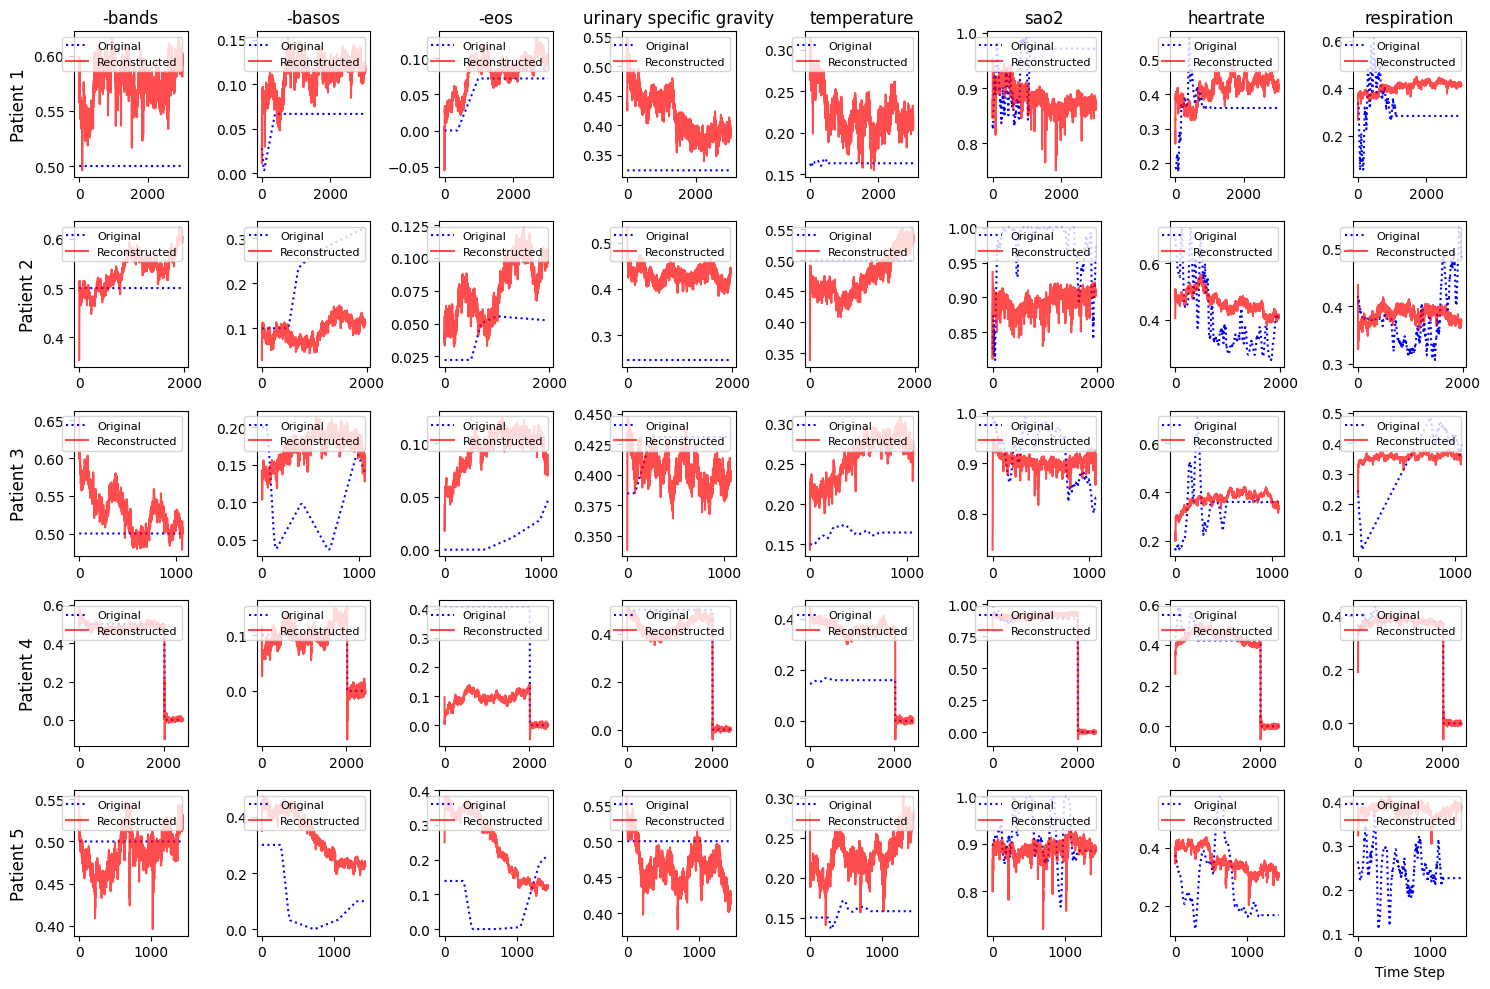

In [6]:
stage3_cpt = os.path.join(base_dir, "stage3/joint_epoch090.pth")

model.load_state_dict(torch.load(stage3_cpt, map_location=device,weights_only=True))


with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model, test_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)